# 概要

PyTorchを使ってLSTMで文章分類を実装してみた

https://qiita.com/m__k/items/841950a57a0d7ff05506

# データ準備

In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
import linecache
from IPython.display import Image

In [2]:
# カテゴリを配列で取得
categories = [name for name in os.listdir("text") if os.path.isdir("text/" + name)]
print(categories)

['dokujo-tsushin', 'it-life-hack', 'kaden-channel', 'livedoor-homme', 'movie-enter', 'peachy', 'smax', 'sports-watch', 'topic-news']


In [3]:
datasets = pd.DataFrame(columns=["title", "category"])
print(f"type: ${type(datasets)}")
print(f"shape: ${datasets.shape}")
datasets

type: $<class 'pandas.core.frame.DataFrame'>
shape: $(0, 2)


,title,category


In [4]:
for cat in categories:
    path = "text/" + cat + "/*.txt"
    files = glob(path)
    for text_name in files:
        title = linecache.getline(text_name, 3)
        s = pd.Series([title, cat], index=datasets.columns)
        datasets = datasets.append(s, ignore_index=True)

print(f"type: ${type(datasets)}")
print(f"shape: ${datasets.shape}")
datasets

type: $<class 'pandas.core.frame.DataFrame'>
shape: $(7376, 2)


,title,category
0,友人代表のスピーチ、独女はどうこなしている？\n,dokujo-tsushin
1,ネットで断ち切れない元カレとの縁\n,dokujo-tsushin
2,相次ぐ芸能人の“すっぴん”披露 その時、独女の心境は？\n,dokujo-tsushin
3,ムダな抵抗！？ 加齢の現実\n,dokujo-tsushin
4,税金を払うのは私たちなんですけど！\n,dokujo-tsushin
...,...,...
7371,爆笑問題・田中裕二も驚く「ひるおび!」での恵俊彰の“天然”ぶり\n,topic-news
7372,黒田勇樹のDV騒動 ネット掲示板では冷ややかな声も\n,topic-news
7373,サムスンのアンドロイド搭載カメラが韓国で話題に\n,topic-news
7374,米紙も注目したゲーム「竹島争奪戦」\n,topic-news


In [5]:
# データフレームシャッフル
datasets = datasets.sample(frac=1).reset_index(drop=True)
datasets.head()

,title,category
0,『荒川アンダー ザ ブリッジ』の“荒川ワールド”満載な予告＆ポスターが公開\n,movie-enter
1,鳥越俊太郎、妊娠発表した矢沢心に「子どもは希望」\n,movie-enter
2,世界11カ国13都市で先行イベントを同時開催「スパイダーマンの武器は“軽口”」\n,movie-enter
3,ベルセルク“100人斬り”のグルメメニュー\n,movie-enter
4,【Sports Watch】長谷部がカズ一家と会食、「理想の家族像」\n,sports-watch


# インプットデータの前処理

PyTorchでLSTMをする際、食わせるインプットデータは３次元のテンソルある必要があります。具体的には、文章の長さ × バッチサイズ × ベクトル次元数 となっています。今回のインプットデータは文章（livedoorニュースのタイトル文）であり、この文章を3次元テンソルに変換する必要があります。

バッチサイズは一旦無視して、ひとまず文章を以下のように２次元のマトリクスに変換することを考えます。

```
人口知能は人間の仕事を奪った
（形態素解析）→['人口','知能','は','人間','の','仕事','を','奪っ','た']
(各単語をベクトルで置換)→[[0.2 0.5 -0.9 1.3 ...], # 「人口」の単語ベクトル
                     [1.3 0.1 2.9 -1.3 ...], # 「知能」の単語ベクトル
                      ...
                     [0.9 -0.3 -0.1 3.0 ...] # 「た」の単語ベクトル
                    ]
```
単語のベクトルは例えばWord2Vecで学習済みのものがあればそれを使う方が精度が良いらしいですが、一旦はPyTorchの torch.nn.Embedding を使いましょう。こいつの詳細はPyTorchのチュートリアルに任せますが、要はランダムな単語ベクトル群を生成してくれるやつです。実際に使ってみると分かりやすいです。


In [6]:
import torch
torch.set_printoptions(linewidth=1000)

import torch.nn as nn
import MeCab
import re

# 実行する前に下記を実行すること
# cp -p /etc/mecabrc /usr//local/etc/

tagger = MeCab.Tagger("-Owakati")
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.device_count())

1.8.1+cu102
False
0


In [7]:
# 以下の宣言で行が単語ベクトル、列が単語のインデックスのマトリクスを生成してる感じ
embeds = nn.Embedding(10, 6) # (Embedding(単語の合計数（vocab_size:1つの文を構成する単語数）, ベクトル次元数（embedding_dim）)

In [8]:
print(f"type: ${type(embeds)}")

type: $<class 'torch.nn.modules.sparse.Embedding'>


In [9]:
embeds

Embedding(10, 6)

In [10]:
# ３行目の要素を取り出したいならば
w1 = torch.tensor([2])
print(embeds(w1))

tensor([[ 1.4692,  1.5176, -1.2082, -1.2317, -1.7746,  1.7654]], grad_fn=<EmbeddingBackward>)


In [11]:
# 3行目、5行目、１０行目の要素を取り出したいならば、
w2 = torch.tensor([2,4,9])
print(embeds(w2))

tensor([[ 1.4692,  1.5176, -1.2082, -1.2317, -1.7746,  1.7654],
        [-0.2252, -1.8256, -0.6420, -0.2368, -1.2482,  1.0709],
        [-0.8372, -1.1405,  0.4718,  0.8076, -1.3962, -1.4320]], grad_fn=<EmbeddingBackward>)


torch.nn.Embeddingを使えば文章を簡単に２次元のマトリクスにすることができます。そのために、文章を単語IDの系列データとして変換すれば、さくっと文章を２次元のマトリクスにできそうです。文章を形態素解析して、全ての単語にIDを割り振って、文章を単語IDの系列データにする前の一連の流れは、例えば以下のような感じでよいでしょう。
（形態素解析にはとりえあずMeCab使います。前処理で英数字や記号は諸々削除していますが、実際は要件に応じて相談。）

In [12]:
def make_wakati(sentence):
    # MeCabで分かち書き
    sentence = tagger.parse(sentence)
    # 半角全角英数字除去
    sentence = re.sub(r'[0-9０-９a-zA-Zａ-ｚＡ-Ｚ]+', " ", sentence)
    # 記号もろもろ除去
    sentence = re.sub(r'[\．_－―─！＠＃＄％＾＆\-‐|\\＊\“（）＿■×+α※÷⇒—●★☆〇◎◆▼◇△□(：〜～＋=)／*&^%$#@!~`){}［］…\[\]\"\'\”\’:;<>?＜＞〔〕〈〉？、。・,\./『』【】「」→←○《》≪≫\n\u3000]+', "", sentence)
    # スペースで区切って形態素の配列へ
    wakati = sentence.split(" ")
    # 空の要素は削除
    wakati = list(filter(("").__ne__, wakati))
    return wakati

In [13]:
# テスト
test = "【人工知能】は「人間」の仕事を奪った"
print(make_wakati(test))

['人工', '知能', 'は', '人間', 'の', '仕事', 'を', '奪っ', 'た']


In [14]:
# 単語ID辞書を作成する
word2index = {}
for title in datasets["title"]:
    wakati = make_wakati(title)
    for word in wakati:
        if word in word2index: continue
        word2index[word] = len(word2index)
print("vocab size : ", len(word2index))

vocab size :  13276


In [15]:
# 文章を単語IDの系列データに変換
# PyTorchのLSTMのインプットになるデータなので、もちろんtensor型で
def sentence2index(sentence):
    wakati = make_wakati(sentence)
    return torch.tensor([word2index[w] for w in wakati], dtype=torch.long)

# テスト
test = "例のあのメニューも！ニコニコ超会議のフードコートメニュー14種類紹介（前半）"
test_result = sentence2index(test)
print(test_result)
print(type(test_result))

tensor([ 170,    4,  171,   40,   51,  172,  173,  174,    4,  175,  176,  177, 7256])
<class 'torch.Tensor'>


In [16]:
# 単語のベクトル数
EMBEDDING_DIM = 10
# 全単語数を取得
VOCAB_SIZE = len(word2index)
VOCAB_SIZE

13276

In [17]:
test = "ユージの前に立ちはだかったJOY「僕はAKBの高橋みなみを守る」"
# 単語IDの系列データに変換
inputs = sentence2index(test)

print(type(inputs))
print(inputs)

<class 'torch.Tensor'>
tensor([6287,    4,  528,   20, 6288,   17, 1956,   22,    4, 1227, 5951,   30,  853])


In [18]:
# 各単語のベクトルをまとめて取得
# 以下の宣言で行が単語ベクトル、列が単語のインデックスのマトリクスを生成してる感じ
# (Embedding(単語の合計数（1つの文を構成する単語数）, ベクトル次元数))
embeds = nn.Embedding(VOCAB_SIZE, EMBEDDING_DIM)

print(type(embeds))
print(embeds)

<class 'torch.nn.modules.sparse.Embedding'>
Embedding(13276, 10)


In [19]:
sentence_matrix = embeds(inputs)
print(type(sentence_matrix))
print(sentence_matrix.size())
print(sentence_matrix)
print("###################テスト終わり#####################")

<class 'torch.Tensor'>
torch.Size([13, 10])
tensor([[ 0.1163,  0.0808, -0.8505,  0.1145,  1.3228,  0.8887, -1.0354, -2.2521, -0.4819,  0.9509],
        [-0.3493, -0.3864, -0.6802,  0.4547, -0.0387, -0.9456,  0.5236, -0.0279, -1.3820,  0.5706],
        [ 0.6795, -0.3567, -1.6689,  0.3254,  1.0259, -1.4004,  0.8470, -0.3022, -0.7662,  0.0197],
        [ 0.5192, -0.5111, -0.9062, -1.0248,  0.4051, -0.9207,  0.4463, -1.0880,  0.3895, -0.9700],
        [ 0.7938,  0.0248, -1.5004, -0.8933, -0.0466,  0.3931, -0.1228,  0.7092, -0.5930,  1.4438],
        [ 0.4641,  0.2499, -0.4656, -0.0508, -1.0517, -0.9389, -0.1216, -0.7436,  0.8558, -0.1894],
        [-1.3185, -0.4758,  1.5142, -0.4748,  0.7781,  1.2064,  0.4713,  0.1332,  0.9647,  0.6530],
        [-0.1208,  0.6609,  0.1980,  1.2031,  1.0543,  0.1976,  1.0020,  1.0501,  1.7384,  0.0835],
        [-0.3493, -0.3864, -0.6802,  0.4547, -0.0387, -0.9456,  0.5236, -0.0279, -1.3820,  0.5706],
        [-0.4163, -2.2496, -1.0603, -0.5601, -0.7060, -0

# モデル定義
これからLSTMによる分類器の作成に入るわけですが、PyTorchでLSTMを使う場合、torch.nn.LSTMを使います。こいつの詳細はPyTorchのチュートリアルを見るのが良いですが、どんなものかはとりあえず使ってみると見えてきます。

今回は（とりあえず）バッチサイズは１とします。上記のように文章を２次元のマトリクスにしたのですが、PyTorchのtensor型なので、view関数を使えばいい感じに変換できます。viewについてはPyTorchのチュートリアルを見るのがよいですが、要は以下のような感じで。

>sentence_matrix.view(len(sentence_matrix), 1, -1).size()  
>=> torch.Size([13, 1, 10])

In [20]:
VOCAB_SIZE = len(word2index)
EMBEDDING_DIM = 10
HIDDEN_DIM = 128
embeds = nn.Embedding(VOCAB_SIZE, EMBEDDING_DIM)
s1 = "震災をうけて感じた、大切だと思ったこと"
print(make_wakati(s1))

['震災', 'を', 'うけ', 'て', '感じ', 'た', '大切', 'だ', 'と', '思っ', 'た', 'こと']


In [21]:
inputs1 = sentence2index(s1)
emb1 = embeds(inputs1)
lstm_inputs1 = emb1.view(len(inputs1), 1, -1)
lstm = nn.LSTM(EMBEDDING_DIM, HIDDEN_DIM)
out1, out2 = lstm(lstm_inputs1)
print(f"out1.size():${out1.size()}")
print(out1)
print(f"out2[0].size():${out2[0].size()}")
print(f"out2[1].size():${out2[1].size()}")
print(out2)

out1.size():$torch.Size([12, 1, 128])
tensor([[[ 0.0288,  0.0606,  0.0231,  ...,  0.1073, -0.0524, -0.0020]],

        [[ 0.0308,  0.0180,  0.0357,  ...,  0.1211, -0.0395,  0.0176]],

        [[ 0.0269,  0.0424,  0.0534,  ...,  0.1430, -0.0002,  0.0757]],

        ...,

        [[ 0.0193,  0.0504,  0.0119,  ...,  0.1011, -0.0119,  0.1086]],

        [[ 0.0242, -0.1103, -0.0256,  ...,  0.0844, -0.0038,  0.0384]],

        [[-0.0986, -0.0794,  0.0504,  ...,  0.0210, -0.0362, -0.0115]]], grad_fn=<StackBackward>)
out2[0].size():$torch.Size([1, 1, 128])
out2[1].size():$torch.Size([1, 1, 128])
(tensor([[[-9.8626e-02, -7.9370e-02,  5.0377e-02,  2.4082e-02, -5.0505e-02,  7.1376e-02,  3.8676e-03, -3.2759e-02, -7.3487e-02, -2.1767e-02,  2.0168e-02, -4.0860e-02,  8.0894e-03,  2.6736e-02,  3.7511e-02,  3.7125e-02, -1.0853e-02,  1.1712e-01, -2.7122e-02, -3.2928e-02, -1.4674e-02, -2.1675e-03, -6.0392e-02, -7.2016e-02,  3.2186e-02, -6.6630e-02,  7.7308e-03,  4.4564e-02, -1.7273e-02, -5.0320e-02, -4.6

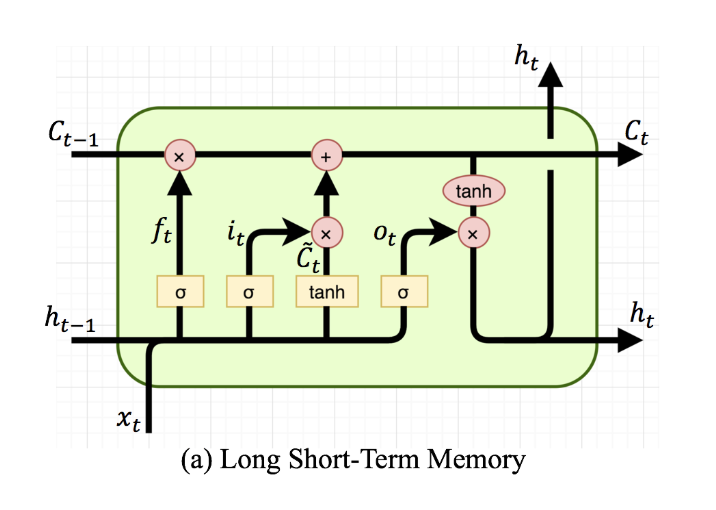

In [22]:
Image("./doc/image/lstm_model.png")

LSTMの(隠れ層の)ネットワークは上図の通り３つ（上矢印の$h_{t}$, $C_{t}$, 右矢印の$h_{t}$）あるが、これらがtorch.nn.LSTMの各戻り値に対応している。  
※単語数分、このLSTM枠が右に続く感じ。

* out1 → output :全ての隠れ層の(上矢印の)$h_{t}$が入っているリストである。上記の例でいえば、「震災」が入っている$x_{1}$の隠れ層の出力$h_{1}$がout1[0]である。また、次の隠れ層において、直前の隠れ層の出力out1[0]（$h_{1}$と「を」が入っている$x_{2}$の$h_{2}$がout1[1]であり...といった感じ。上の例はインプットの系列の長さが12なので、当然len(out1) = 12となる。
* out2 → (h_t, C_t): 最後の隠れ層の$h_{t}$と$c_{t}$である。つまり上記の例で言えば、out1[11] = out2[0]である。※out2[1]は最後の隠れ層の$c_{t}$の方。

これらのどの戻り値を使うべきかは、LSTMで解きたいタスクによります。

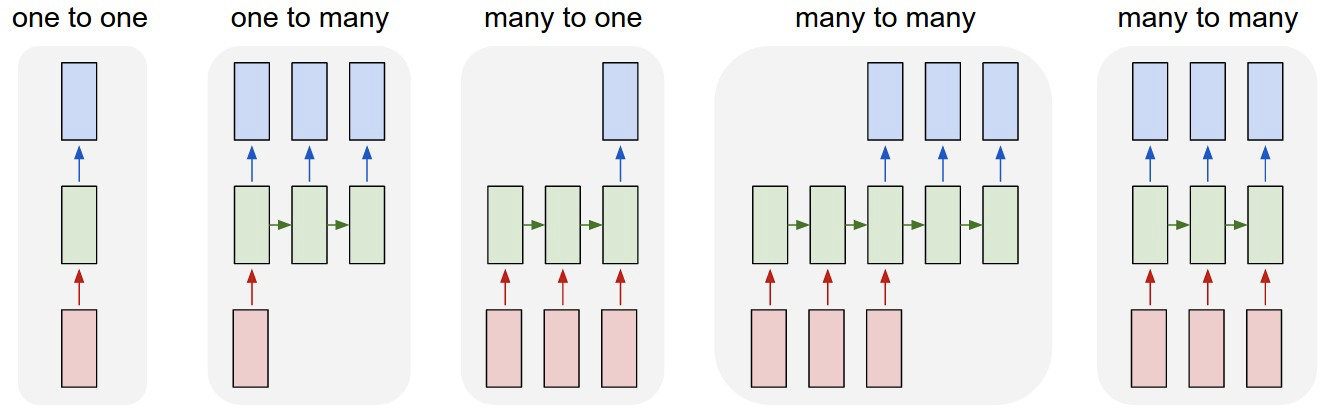

In [23]:
Image("./doc/image/lstm_model2.png")

今回の例で言えば、文章(many)を１つのカテゴリに分類(one)したいので、 many to one のモデルです。なので、LSTMの最後の隠れ層の出力$h_{t}$を使うことになるでしょう。上記の例で言えばout1[11]かout2[0]を使えば良いことになります。many to manyのタスクを解きたければLSTMの第一戻り値を使えばよいです。

あとは、LSTMの戻り値を全結合層で次元を整えながらsoftmax食わせて出力すればOK。例えば以下の様な感じ。

In [25]:
# nn.Moduleを継承して新しいクラスを作る。決まり文句
class LSTMClassifier(nn.Module):
    # モデルで使う各ネットワークをコンストラクタで定義
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        # 親クラスのコンストラクタ。決まり文句
        super(LSTMClassifier, self).__init__()
        # 隠れ層の次元数。これは好きな値に設定しても行列計算の過程で出力には出てこないので。
        self.hidden_dim = hidden_dim
        # インプットの単語をベクトル化するために使う
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        # LSTMの隠れ層。これ１つでOK。超便利。
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        # softmaxのLog版。dim=0で列、dim=1で行方向を確率変換。
        self.softmax = nn.LogSoftmax(dim=1)

    # 順伝播処理はforward関数に記載
    def forward(self, sentence):
        # 文章内の各単語をベクトル化して出力。2次元のテンソル
        embeds = self.word_embeddings(sentence)
        # 2次元テンソルをLSTMに食わせられる様にviewで３次元テンソルにした上でLSTMへ流す。
        # 上記で説明した様にmany to oneのタスクを解きたいので、最後の隠れ層の戻り値である第二戻り値だけ使う。
        _, lstm_out = self.lstm(embeds.view(len(sentence), 1, -1))
        # lstm_out[0]は３次元テンソルになってしまっているので2次元に調整して全結合。
        tag_space = self.hidden2tag(lstm_out[0].view(-1, self.hidden_dim))
        # softmaxに食わせて、確率として表現
        tag_scores = self.softmax(tag_space)
        return tag_scores

# 正解ラベルの変換

上記のネットワークのoutputがいわば予測の結果になるわけですが、その形式をみると、

> tensor([[ -0.5003,  -3.5191,  -8.0818,  -2.5900,  -8.1883,  -8.2956, -11.2307,
         -11.2474,  -1.2442]], grad_fn=<LogSoftmaxBackward>)

こんな感じでtorch.Size([1, 9])となっています。今回分類したいカテゴリの数が全部で９つあったので、要素が９個あるわけです。これの意味するところは各要素が各カテゴリである確率的なものを表しています。（LogSoftmaxなので、0~1の値ではないですが）
一番大きい値がネットワークの予測結果として使うことができます。
なので、各要素をどのカテゴリの確率にするかをこちらで決めないといけないわけですが、そのために以下のように分類先のカテゴリにIDを割り振って、そのIDの値を持つtensorを返す関数を用意します。

In [27]:
category2index = {}
for cat in categories:
    if cat in category2index: continue
    category2index[cat] = len(category2index)
print(category2index)
#{'movie-enter': 0, 'it-life-hack': 1, 'kaden-channel': 2, 'topic-news': 3, 'livedoor-homme': 4, 'peachy': 5, 'sports-watch': 6, 'dokujo-tsushin': 7, 'smax': 8}

def category2tensor(cat):
    return torch.tensor([category2index[cat]], dtype=torch.long)

print(category2tensor("it-life-hack"))
# tensor([1])

# これを上のネットワークの予測結果と共に損失関数のインプットとして使います。

{'dokujo-tsushin': 0, 'it-life-hack': 1, 'kaden-channel': 2, 'livedoor-homme': 3, 'movie-enter': 4, 'peachy': 5, 'smax': 6, 'sports-watch': 7, 'topic-news': 8}
tensor([1])


# 学習
ここまでくれば、あとは上記のモデルで系列を学習すれば良いです。損失関数や最適化の手法は一旦チュートリアルに記載されているものをそのまま使いましょう。例えば以下の様な感じで。

In [31]:
from sklearn.model_selection import train_test_split
import torch.optim as optim
# 元データを7:3に分ける（7->学習、3->テスト）
traindata, testdata = train_test_split(datasets, train_size=0.7)
print(traindata)

                                                  title        category
1052                 『アリス・イン・ワンダーランド』スタッフ最新作は、“戦う”白雪姫\n     movie-enter
1257  NTTドコモ、Android 4.0 ICS搭載4.5インチスマホ「AQUOS PHONE ...            smax
2708  通話に便利な機能と落ち着いたカラーリングが渋い！アクティブシニア向けなPHS音声端末「Cas...            smax
5993                            古来より伝わる「植物療法」で肌質改善宣言！\n          peachy
7220    【Sports Watch】中田英、日本惜敗も「勝ちにいく姿勢が見えたっていうのは大きい」\n    sports-watch
...                                                 ...             ...
91                    “新たな一歩を願って”チヨダが靴などを宮城県災害対策本部に寄付\n  livedoor-homme
1524                         時代は「3平」へ。イマドキの結婚相手の条件とは？\n  dokujo-tsushin
6882       アインシュタインが「宇宙最強」と命名した「iCompaund」で複利を理解【デジ通】\n    it-life-hack
6107                      “働く女性のための”カクテルパーティ付映画鑑賞会を開催\n          peachy
1787                   【ニュース】NTTドコモがイギリスのボーダフォンと事業提携へ\n   kaden-channel

[5163 rows x 2 columns]


In [32]:
# 単語のベクトル次元数
EMBEDDING_DIM = 10
# 隠れ層の次元数
HIDDEN_DIM = 128
# データ全体の単語数
VOCAB_SIZE = len(word2index)
# 分類先のカテゴリの数
TAG_SIZE = len(categories)
# モデル宣言
model = LSTMClassifier(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TAG_SIZE)
# 損失関数はNLLLoss()を使う。LogSoftmaxを使う時はこれを使うらしい。
loss_function = nn.NLLLoss()
# 最適化の手法はSGDで。lossの減りに時間かかるけど、一旦はこれを使う。
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [33]:
# 各エポックの合計loss値を格納する
losses = []
# 100ループ回してみる。（バッチ化とかGPU使ってないので結構時間かかる...）
for epoch in range(100):
    all_loss = 0
    for title, cat in zip(traindata["title"], traindata["category"]):
        # モデルが持ってる勾配の情報をリセット
        model.zero_grad()
        # 文章を単語IDの系列に変換（modelに食わせられる形に変換）
        inputs = sentence2index(title)
        # 順伝播の結果を受け取る
        out = model(inputs)
        # 正解カテゴリをテンソル化
        answer = category2tensor(cat)
        # 正解とのlossを計算
        loss = loss_function(out, answer)
        # 勾配をセット
        loss.backward()
        # 逆伝播でパラメータ更新
        optimizer.step()
        # lossを集計
        all_loss += loss.item()
    losses.append(all_loss)
    print("epoch", epoch, "\t" , "loss", all_loss)
print("done.")

epoch 0 	 loss 10899.660962760448
epoch 1 	 loss 9930.39332363382
epoch 2 	 loss 9326.724101057276
epoch 3 	 loss 8839.146893428639
epoch 4 	 loss 8309.597791422158
epoch 5 	 loss 7739.572728243191
epoch 6 	 loss 7199.642693646019
epoch 7 	 loss 6760.257367182057
epoch 8 	 loss 6351.956748124096
epoch 9 	 loss 5948.0119256552425
epoch 10 	 loss 5580.666941437405
epoch 11 	 loss 5228.01967024483
epoch 12 	 loss 4855.24015348604
epoch 13 	 loss 4510.149409467784
epoch 14 	 loss 4067.4626389265395
epoch 15 	 loss 3655.88323251329
epoch 16 	 loss 3234.126688253382
epoch 17 	 loss 2813.7354267397313
epoch 18 	 loss 2371.764095127584
epoch 19 	 loss 2017.1996329740132
epoch 20 	 loss 1672.8899567451033
epoch 21 	 loss 1261.6634959789503
epoch 22 	 loss 971.3880378823167
epoch 23 	 loss 746.3673995577168
epoch 24 	 loss 664.5744913586802
epoch 25 	 loss 497.4304809752333
epoch 26 	 loss 394.06494750225806
epoch 27 	 loss 239.58115473836705
epoch 28 	 loss 175.0185374213824
epoch 29 	 loss 131

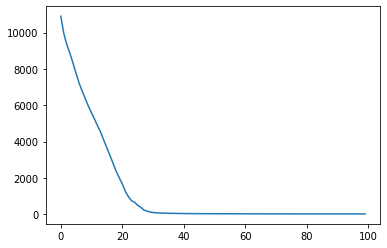

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(losses)

# 予測精度確認
学習したモデルを使ってテストデータを評価してみます。下記のポイントはtorch.no_grad()です。with torch.no_grad():以下に書かれたコードでは、データがネットワークを通る際にautogradによる勾配の自動計算を行わないようにしています。

In [36]:
# テストデータの母数計算
test_num = len(testdata)
# 正解の件数
a = 0
# 勾配自動計算OFF
with torch.no_grad():
    for title, category in zip(testdata["title"], testdata["category"]):
        # テストデータの予測
        inputs = sentence2index(title)
        out = model(inputs)

        # outの一番大きい要素を予測結果をする
        _, predict = torch.max(out, 1)

        answer = category2tensor(category)
        if predict == answer:
            a += 1
print("predict : ", a / test_num)

predict :  0.6086760054225034


# ちょっとだけ分析
## 過学習を疑う
学習データで予測してみると...思いっきり過学習してるっぽいかも...

In [37]:
traindata_num = len(traindata)
a = 0
with torch.no_grad():
    for title, category in zip(traindata["title"], traindata["category"]):
        inputs = sentence2index(title)
        out = model(inputs)
        _, predict = torch.max(out, 1)
        answer = category2tensor(category)
        if predict == answer:
            a += 1
print("predict : ", a / traindata_num)

predict :  0.9986441991090451


## Fスコアを見てみる

In [38]:
import collections
# IDをカテゴリに戻す用
index2category = {}
for cat, idx in category2index.items():
    index2category[idx] = cat

# answer -> 正解ラベル、predict->LSTMの予測結果、exact->正解してたらO,間違っていたらX
predict_df = pd.DataFrame(columns=["answer", "predict", "exact"])

# 予測して結果を上のDFに格納
with torch.no_grad():
    for title, category in zip(testdata["title"], testdata["category"]):
        out = model(sentence2index(title))
        _, predict = torch.max(out, 1)
        answer = category2tensor(category)
        exact = "O" if predict.item() == answer.item() else "X"
        s = pd.Series([answer.item(), predict.item(), exact], index=predict_df.columns)
        predict_df = predict_df.append(s, ignore_index=True)

# Fスコア格納用のDF
fscore_df = pd.DataFrame(columns=["category", "all","precison", "recall", "fscore"])

# 分類器が答えた各カテゴリの件数
prediction_count = collections.Counter(predict_df["predict"])
# 各カテゴリの総件数
answer_count = collections.Counter(predict_df["answer"])

# Fスコア求める
for i in range(9):
    all_count = answer_count[i]
    precision = len(predict_df.query('predict == ' + str(i) + ' and exact == "O"')) / prediction_count[i]
    recall = len(predict_df.query('answer == ' + str(i) + ' and exact == "O"')) / all_count
    fscore = 2*precision*recall / (precision + recall)
    s = pd.Series([index2category[i], all_count, round(precision, 2), round(recall, 2), round(fscore, 2)], index=fscore_df.columns)
    fscore_df = fscore_df.append(s, ignore_index=True)
print(fscore_df)

         category  all  precison  recall  fscore
0  dokujo-tsushin  257      0.66    0.65    0.65
1    it-life-hack  246      0.61    0.65    0.63
2   kaden-channel  224      0.79    0.81    0.80
3  livedoor-homme  166      0.48    0.46    0.47
4     movie-enter  266      0.49    0.51    0.50
5          peachy  258      0.50    0.48    0.49
6            smax  296      0.86    0.83    0.84
7    sports-watch  257      0.47    0.54    0.50
8      topic-news  243      0.58    0.49    0.53


Fスコアに結構ばらつきがあります。smax、kaden-channelは良さげだけど、peachy、sports-watchがよろしくなさげ。
topic-newsが一番悪くなると思ってたけど、そういうわけでもなかった。（topic-newsはカテゴリというよりかは主要ニュースって感じでカテゴリが限定されているわけではないので）

本記事はあくまでPyTorchによるLSTMの実装方法が目的なので、今回の問題に対する精度については、これ以上立ち入らない様にしますが、これ以上精度をあげるなら、

各カテゴリの誤判定（なんのカテゴリをなんのカテゴリを勘違いしたか）を集計してみる
ってか形態素が雑（せめて品詞を限定するとかstopwords入れるとかして）
こういったニュース記事のタイトルの分類って各分類で特定の単語とか使われてそうだから、LSTMなんかよりも無難にword2vecやTF-IDFでまずやってみる
ってかまずはデータをよく見ろ
とかしたほうがいいんだろうなぁと思いました。